<a href="https://colab.research.google.com/github/ni-metre/Colab_Triplet_Loss_Backup/blob/master/Omit5percentCO2_Generate_Hybrid_Fake_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Set up gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [2]:
% xmode verbose

Exception reporting mode: Verbose


In [3]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#To remoount drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
# Load the Pandas libraries with alias 'pd' 
import sys
import os
import os.path
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt


import datetime as datetime
import math
import random




### Reading in the Test_Log of real data (**test_db_df**)to create a record of fake data (**fake_test_db_df**)

In [5]:
#Define folder for outputs (and make it if it doesn't exist)
sensor_of_interest = 24
base_dir_name = 'Drop_V3_Fakes/'
descriptor = 'V3_no_5perCO2_'+ str(sensor_of_interest)


logname = 'Fake_Test_Log_for_' + descriptor + '.csv'
base_path = '/content/drive/My Drive/' + base_dir_name
output_path = base_path + descriptor 

if not os.path.exists(output_path):
    os.makedirs(output_path)



In [6]:

#Run this to define import function, which gets called in each plotting function (in case Test_Log is updated)
def do_import():
  wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1xHVjmlRynUE6YYZFh8rvOuFd7Mb-eWHIIwvsTvndFkY/edit?usp=sharing')
  sheet = wb.worksheet('Test_Log')
  test_data = sheet.get_all_values()
  test_df = pd.DataFrame(test_data)

  test_df.columns = test_df.iloc[0]
  test_df  = test_df .iloc[1:]


  test_df['Sensor']= test_df['Sensor'].replace("?", 0)
  for column in test_df[['Acetone', 'CO2', 'H2O', 'Sensor','File', 'Test_that_day', 'Time_Btwn_s', 'Instr_Temp', 'Baseline', 'Total_CO2', 'New_Baseline', 'Sample_rate']]:
      test_df[column] = pd.to_numeric(test_df[column])
  test_db_df = test_df.set_index('File')
  return(test_db_df)

In [7]:
#Check that Test_Log looks okay
test_db_df = do_import()

test_db_df.fillna(0, inplace= True)
test_db_df.head()

,Raw_data,Test_name,H2O,CO2,Total_CO2,Acetone,Sample_rate,Gain,Gain_Adj,Sensor,Instr_Temp,Date,Time,Time_Btwn_s,Test_that_day,FLAG,Notes,Data_pts,Baseline,Amb_Temp,Other,Instr,Rel_Hum,EtOH_temp,Instr_T2,Instr_T3,New_Baseline,Baseline_Dip,Peak_neg,Peak_pos,Peak_neg_t,Peak_pos_t,Cross_t,Cross_t_ix,Peak_neg_t_ix,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,dx2_cross_t_ix
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000,wav3000,Nitrogen blank,0,0,0.0,0.0,250,,,7,0.0,2020-02-11,1:53:44 PM,50024.0,1,,,8076,26.770204,0,0.00,38107,0.00,0,,,26.0,-0.84,-2.495264403,34.0613,18.4200,1.32,0.00,0,1842.00000,132,0.00,-1060.00,0.00,0.00,...,0,0,0.13728,-0.73976,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.6115311406,0.3,30,-0.1127246342,2.58,258,6.98,698,0.03976674596,0.21,21,-0.01064621545,0.45,45,1.88,188,188
3001,wav3000,Nitrogen blank,0,0,0.0,0.0,250,,,6,0.0,2020-02-11,1:54:02 PM,50042.0,1,,,6253,25.223295,0,0.00,38263,0.00,0,,,25.0,0.0446,-3.68,4.53E+01,10.3000,1.14E+00,0.00,0.00E+00,1030.00000,1.14E+02,0.00,1737.00,0.00,0.00,...,0,0,0.07312,-0.6294,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9091349749,0.29,29,-0.145461596,2.57,257,8.25,825,0.06433878284,0.21,21,-0.01647321493,0.49,49,1.8,180,180
3002,wav3001,Nitrogen blank,0,0,0.0,0.0,250,,,7,0.0,2020-02-11,1:56:27 PM,163.0,2,,,5380,26.311880,0,0.00,38107,0.00,0,,,26.0,0.0605,-2.476566964,38.7806,18.0500,1.27,0.00,0,1805.00000,127,0.00,5373.00,0.00,0.00,...,0,0,0.01004,-0.67635,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.721437659,0.29,29,-0.1183608659,2.76,276,7.92,792,0.05009983743,0.22,22,-0.01189871139,0.48,48,1.76,176,176
3003,wav3001,Nitrogen blank,0,0,0.0,0.0,250,,,6,0.0,2020-02-11,1:56:36 PM,154.0,2,,,4455,25.250096,0,0.00,38263,0.00,0,,,25.0,-0.0134,-3.71,4.56E+01,11.8000,1.15E+00,0.00,0.00E+00,1180.00000,1.15E+02,0.00,5217.00,0.00,0.00,...,0,0,0,-0.3147,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9063376365,0.3,30,-0.1398669192,2.44,244,8.37,837,0.06278470596,0.22,22,-0.01491913805,0.52,52,1.72,172,172
3004,wav3002,Nitrogen blank,0,0,0.0,0.0,250,,,7,0.0,2020-02-11,2:04:19 PM,472.0,3,,,4184,26.724979,0,0.00,38107,0.00,0,,,27.0,0.1782,-2.078048257,32.9568,18.1300,1.29,0.00,0,1813.00000,129,0.00,6489.00,0.00,0.00,...,0,0,0.0067,-0.67635,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.6058949089,0.3,30,-0.1042702866,2.47,247,7.64,764,0.04383735775,0.22,22,-0.009393719518,0.48,48,1.75,175,175


In [8]:
fake_test_db_df = pd.DataFrame(test_db_df.loc[test_db_df['Sensor'] == sensor_of_interest])

fake_test_db_df.head(-1)


,Raw_data,Test_name,H2O,CO2,Total_CO2,Acetone,Sample_rate,Gain,Gain_Adj,Sensor,Instr_Temp,Date,Time,Time_Btwn_s,Test_that_day,FLAG,Notes,Data_pts,Baseline,Amb_Temp,Other,Instr,Rel_Hum,EtOH_temp,Instr_T2,Instr_T3,New_Baseline,Baseline_Dip,Peak_neg,Peak_pos,Peak_neg_t,Peak_pos_t,Cross_t,Cross_t_ix,Peak_neg_t_ix,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,dx2_cross_t_ix
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11001,jdata11001,4% CO2 through plain water,10,40000,0.0,0.0,250,441.58,,24,25.32,2020-12-29,8:38:02 AM,100000.0,1,,,24976,27.264094,,,24,,,,,0.0,,-67.28440625,4.59528125,1.8880,13.224,8.23,1585,472,3306,,,-243,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11003,jdata11003,4% CO2 through plain water,10,40000,0.4,0.0,250,441.58,,24,25.33,2020-12-29,8:47:05 AM,543.0,2,,,24976,27.252156,,,24,,,,,0.0,,-69.69559375,4.80253125,1.8880,13.196,8.22,1582,472,3299,,,-251,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11005,jdata11005,5% CO2 through plain water,10,50000,0.9,0.0,250,441.58,,24,25.43,2020-12-29,8:56:02 AM,537.0,3,,,24976,27.195487,,,24,,,,,0.0,,-88.575175,6.07795,1.9000,13.132,8.25,1587,475,3283,,,-321,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11007,jdata11007,5% CO2 through plain water,10,50000,1.4,0.0,250,441.58,,24,25.45,2020-12-29,9:05:07 AM,545.0,4,,,24976,27.235444,,,24,,,,,0.0,,-90.01106875,6.28018125,1.9040,12.888,8.23,1582,476,3222,,,-326,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11009,jdata11009,6% CO2 through plain water,10,60000,2.0,0.0,250,441.58,,24,25.49,2020-12-29,9:14:03 AM,536.0,5,,,24976,27.204350,,,24,,,,,0.0,,-109.004975,7.4909625,1.9160,13.08,8.28,1592,479,3270,,,-398,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11989,jdata11989,6% CO2 through 50 ppm acetone,10,60000,247.0,50.0,250,258.51,1.7,24,26.65,2021-01-22,11:57:01 AM,600.0,19,,,24976,27.457964,,,24,,,,,0.0,,-430.7076128,38.38946517,2.6640,19.812,12.56,2473,666,4953,,,-2533,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11991,jdata11991,6% CO2 through 50 ppm acetone,10,60000,247.6,50.0,250,258.51,1.7,24,26.71,2021-01-22,12:09:07 PM,726.0,20,,,24976,27.241966,,,24,,,,,0.0,,-440.8799797,41.32519666,2.6120,20.036,12.58,2492,653,5009,,,-2618,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11993,jdata11993,6% CO2 through 50 ppm acetone,10,60000,248.2,50.0,250,258.51,1.7,24,26.88,2021-01-22,12:18:01 PM,534.0,21,,,24976,27.718279,,,24,,,,,0.0,,-451.7937688,43.17093179,2.5560,20.048,12.70,2537,639,5012,,,-2727,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [9]:
fake_test_db_df = fake_test_db_df.truncate(after = 11252)

In [10]:
print(len(fake_test_db_df))

126


In [11]:
STARTNUM =int(fake_test_db_df.index[-1]) +1
print(STARTNUM)

11252


In [12]:
#Returns a list of tests that meet ALL of the criteria defined in the arguments
# Acetone can be a specific value, 'all', '>(value)' or '<(value)'
# CO2 can be a specific value, 'all' or '+' for CO@ values that are > 0
# H2O must be a specific value, almost always 10 for tests of interest
# Sensor can be a specific sensor number or 'all'
# Range1/2 is the lower and upper limit for the range of tests of interest from range1 to rang2 - 1

def get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):

    if Sensor == 'all':
        filtered = df
    else:
        filtered = df[(df['Sensor'] == Sensor)]
    filtered = filtered.query('FLAG ==""')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            filtered = filtered[filtered['Acetone'].astype(float) < float(Acetone[1:])]
        else:
            if str(Acetone)[:1] == '>':
                filtered = filtered[filtered['Acetone'].astype(float) > float(Acetone[1:])]
            else:
                filtered = filtered[(filtered['Acetone'] == Acetone)]
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered[(filtered['CO2'] != '0')]
        else:
            filtered = filtered[(filtered['CO2'] == CO2)]
    filtered = filtered[(filtered['H2O'] == H2O)]
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])

In [13]:
#Returns a list of tests that meet ALL of the criteria defined in the arguments
# SAME AS get_test_list above for the following
# Acetone can be a specific value, 'all', '>(value)' or '<(value)'
# CO2 can be a specific value, 'all' or '+' for CO@ values that are > 0
# H2O must be a specific value, almost always 10 for tests of interest
# Sensor can be a specific sensor number or 'all'
# Range1/2 is the lower and upper limit for the range of tests of interest from range1 to rang2 - 1
#BUT
# temp is a temperature value in degrees C
# and delta is range in degrees C above and below temp that will be included in the returned list

def get_test_list_Temp (df, Acetone, CO2, H2O, temp, delta, Sensor, Range1, Range2):

    if Sensor == 'all':
        filtered = df
    else:
        filtered = df[(df['Sensor'] == Sensor)]
    filtered = filtered.query('FLAG ==""')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            filtered = filtered[filtered['Acetone'].astype(float) < float(Acetone[1:])]
        else:
            if str(Acetone)[:1] == '>':
                filtered = filtered[filtered['Acetone'].astype(float) > float(Acetone[1:])]
            else:
                filtered = filtered[(filtered['Acetone'] == Acetone)]
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered[(filtered['CO2'] != '0')]
        else:
            filtered = filtered[(filtered['CO2'] == CO2)]
    filtered = filtered[(filtered['H2O'] == H2O)]
    filtered['Tests'] = filtered.index
    filtered['Instr_Temp'] = pd.to_numeric(filtered['Instr_Temp'])
    filtered = filtered[filtered['Instr_Temp']>= temp - delta]
    filtered = filtered[filtered['Instr_Temp']<= temp + delta]
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])

# Defining Functions for grid method of generating fake data

In [14]:
def make_new_fake_real_metadata(signal,num):

    fake_test_db_df.loc[num, 'Data_pts'] = len(signal)
    sample_rate = 250
    peak_pos = signal['mV_rolling_mean'].max()
    peak_pos_t_ix = signal['mV_rolling_mean'].idxmax()
    peak_pos_t = signal.loc[peak_pos_t_ix,'Second']
    fake_test_db_df.loc[num, 'Peak_pos'] = peak_pos
    fake_test_db_df.loc[num, 'Peak_pos_t'] = peak_pos_t
    fake_test_db_df.loc[num, 'Peak_pos_t_ix'] = peak_pos_t_ix
    peak_neg = signal['mV_rolling_mean'].min()
    peak_neg_t_ix = signal['mV_rolling_mean'].idxmin()
    peak_neg_t = signal.loc[peak_neg_t_ix,'Second']
    fake_test_db_df.loc[num, 'Peak_neg'] = peak_neg
    fake_test_db_df.loc[num, 'Peak_neg_t'] = peak_neg_t
    fake_test_db_df.loc[num, 'Peak_neg_t_ix'] = peak_neg_t_ix
    
    pos_data = signal.truncate(before=peak_neg_t_ix, axis=None)
# find x-point --- first trim all negative data
    cross_t_ix = (pos_data['mV_rolling_mean'] >= 0).idxmax()
# get time at x-point
    cross_t = pos_data.loc[cross_t_ix,'Second']
    
    fake_test_db_df.loc[num, 'Cross_t'] = cross_t
    fake_test_db_df.loc[num, 'Cross_t_ix'] = cross_t_ix
        
# get positive area
    pos_data = signal.truncate(before = cross_t_ix)
    pk_8th = peak_pos/8
    pk_16th = peak_pos/16
    tail_data = signal.truncate(before=peak_pos_t_ix)
    last_pt = pos_data['mV_rolling_mean'].values[-1]
    if last_pt < pk_16th:
        pk_16th_t_ix = (tail_data['mV_rolling_mean'] <= pk_16th).idxmax()
        pos_data_16 = pos_data.truncate(after = pk_16th_t_ix)
        area_pos_16 = int(pos_data_16['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_16'] = int(area_pos_16/sample_rate)
#Exclude these calculations for short tests
    if last_pt < pk_8th:
        pk_8th_t_ix = (tail_data['mV_rolling_mean'] <= pk_8th).idxmax()
        pos_data_8 = pos_data.truncate(after = pk_8th_t_ix)
        area_pos_8 = int(pos_data_8['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_8'] = int(area_pos_8/sample_rate)
        area_pos = int(area_pos_8/sample_rate)*1.27-173
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
    else:
        area_pos = 0
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
# get Negative area      
    neg_data = signal.truncate(after = cross_t_ix)
    area_neg = int(neg_data['mV_rolling_mean'].sum()) 
    fake_test_db_df.loc[num, 'Area_neg'] = int(area_neg/sample_rate)
# post total area
    fake_test_db_df.loc[num, 'Area_total'] = area_neg + area_pos
    return fake_test_db_df
    


In [15]:
###Assumes that tests have the same sample rate
def make_a_fake_test_string(test1, test2, filenum, howmany,fake_test_db_df):
    print(test1, test2, filenum)
    new_tests = [test1]
    root_path_1a = output_path + '/test_output' + str(test1) + '.csv'
    root_path_1b ='/content/drive/My Drive/Test_outputs/General/test_output' + str(test1) + '.csv'
    root_path_2a = output_path + '/test_output' + str(test2) + '.csv'
    root_path_2b ='/content/drive/My Drive/Test_outputs/General/test_output' + str(test2) + '.csv'
  
    if os.path.exists(root_path_1a):
      signal1 = pd.read_csv(root_path_1a)
    else:
      signal1 = pd.read_csv(root_path_1b)

    if os.path.exists(root_path_2a):
      signal2 = pd.read_csv(root_path_2a)
    else:
      signal2 = pd.read_csv(root_path_2b)

    len1 = len(signal1.index)
    len2 = len(signal2.index)
    if len1 > len2:
        signal1 = signal1.truncate(after=len2)
    else:
        signal2 = signal2.truncate(after=len1)
    fake_signal = signal2.copy()
    interval = 1/(howmany + 1)
    for i in range(howmany):
        weight = interval * (i+1)
        fake_signal['mV_rolling_mean'] = signal1['mV_rolling_mean']+((signal2['mV_rolling_mean']-signal1['mV_rolling_mean'])*weight)
        fake_signal.to_csv(output_path + '/test_output' + str(filenum) + '.csv', index=False, columns=['Second', 'mV_rolling_mean'])
        fake_test_db_df = write_fake_real_metadata(test1, test2, weight, filenum, fake_test_db_df)
        fake_test_db_df = make_new_fake_real_metadata(fake_signal,filenum)
        new_tests.append(filenum)
        filenum = filenum + 1
    # This writes to test log
    fake_test_db_df.to_csv(base_path + '/' + logname)
    new_tests.append(test2)
    return(new_tests,filenum)
    

In [16]:
def write_fake_real_metadata(test1, test2, weight, num, fake_test_db_df):

    param_list = ['CO2', 'Total_CO2', 'Acetone', 'Time_Btwn_s', 'Test_that_day', 'Instr_Temp', 'Baseline', 'New_Baseline']
    for param in param_list:
        fake_test_db_df[param] = pd.to_numeric(fake_test_db_df[param])
    fake_test_db_df.loc[num, 'File_num'] = num
    fake_test_db_df.loc[num, 'Instr'] = fake_test_db_df.loc[test1, 'Instr']
    fake_test_db_df.loc[num, 'Sensor'] = fake_test_db_df.loc[test1, 'Sensor']
    fake_test_db_df.loc[num, 'Sample_rate'] = 250
    fake_test_db_df.loc[num, 'H2O'] = fake_test_db_df.loc[test1, 'H2O']

    fake_test_db_df.loc[num, 'Test_name'] = 'Combo of ' + str(test1) + ' and ' + str(test2) + ' | Weight - ' + str(weight)
    fake_test_db_df.loc[num, 'CO2'] = (fake_test_db_df.loc[test1, 'CO2']) + (((fake_test_db_df.loc[test2, 'CO2']) - (fake_test_db_df.loc[test1, 'CO2']))*weight)
    fake_test_db_df.loc[num, 'Total_CO2'] = (fake_test_db_df.loc[test1, 'Total_CO2']) + (((fake_test_db_df.loc[test2, 'Total_CO2']) - (fake_test_db_df.loc[test1, 'Total_CO2']))*weight)
    fake_test_db_df.loc[num, 'Acetone'] = (fake_test_db_df.loc[test1, 'Acetone']) + (((fake_test_db_df.loc[test2, 'Acetone']) - (fake_test_db_df.loc[test1, 'Acetone']))*weight)
    fake_test_db_df.loc[num, 'Time_Btwn_s'] = (fake_test_db_df.loc[test1, 'Time_Btwn_s']) + (((fake_test_db_df.loc[test2, 'Time_Btwn_s']) - (fake_test_db_df.loc[test1, 'Time_Btwn_s']))*weight)
    fake_test_db_df.loc[num, 'Test_that_day'] = (fake_test_db_df.loc[test1, 'Test_that_day']) + (((fake_test_db_df.loc[test2, 'Test_that_day']) - (fake_test_db_df.loc[test1, 'Test_that_day']))*weight)
    fake_test_db_df.loc[num, 'Instr_Temp'] = (fake_test_db_df.loc[test1, 'Instr_Temp']) + (((fake_test_db_df.loc[test2, 'Instr_Temp']) - (fake_test_db_df.loc[test1, 'Instr_Temp']))*weight)
    fake_test_db_df.loc[num, 'Baseline'] = (fake_test_db_df.loc[test1, 'Baseline']) + (((fake_test_db_df.loc[test2, 'Baseline']) - (fake_test_db_df.loc[test1, 'Baseline']))*weight)
    fake_test_db_df.loc[num, 'New_Baseline'] = (fake_test_db_df.loc[test1, 'New_Baseline']) + (((fake_test_db_df.loc[test2, 'New_Baseline']) - (fake_test_db_df.loc[test1, 'New_Baseline']))*weight)
    
    return fake_test_db_df


# Defining functions for random weight (i.e. non-grid) method of generating fake data

In [17]:
###Assumes that tests have the same sample rate
def make_rand_weight_fake_test(test1, test2, how_many,filenum):
    sample_rate1 = test_db_df.loc[test1, 'Sample_rate']
    sample_rate2 = test_db_df.loc[test2, 'Sample_rate']
    signal1 = pd.read_csv('/content/drive/My Drive/Test_outputs/General/test_output' + str(test1) + '.csv')
    signal2 = pd.read_csv('/content/drive/My Drive/Test_outputs/General/test_output' + str(test2) + '.csv')
    mV1 = np.array(signal1['mV_rolling_mean'])
    mV2 = np.array(signal2['mV_rolling_mean'])
    s1 =  np.array(signal1['Second'])
    s2 =  np.array(signal2['Second'])
###########
    if sample_rate1 == 500:
      if (len(mV1) %2) ==0:
        pass
      else:
        
        mV1 = mV1[:-1]
        s1 = s1[:-1]

      mV1 = mV1.reshape(-1, 2).mean(axis=1)
      s1 = s1[::2]

    else:
      pass
    if sample_rate2 == 500:
      if (len(mV2) %2) ==0:
        pass
      else:
        mV2 = mV2[:-1]
        s2 = s2[:-1]
      mV2 = mV2.reshape(-1, 2).mean(axis=1)
      s2 =s2[::2]
    else:
      pass
    len1 = len(s1)
    len2 = len(s2)    

    if len1 > len2:
        s1 = s1[:len2]
        mV1 = mV1[:len2]
    else:
        s2 = s2[:len1]
        mV2 = mV2[:len1]    

    ########
   
    for i in range(how_many):
        weight = random.randint(1, 99)/100
        fake_mV = mV1 +((mV2-mV1)*weight)

        fake_signal = pd.DataFrame({"Second": s1, "mV_rolling_mean":fake_mV}) 


        fake_signal.to_csv(output_path + '/test_output' + str(filenum) + '.csv', index=False, columns=['Second', 'mV_rolling_mean'])

        #### str(filenum) might be a problem
        write_rand_weight_meta_data(test1, test2, weight, filenum)
        make_rand_weight_new_metadata(fake_signal,filenum)
        filenum = filenum + 1

In [18]:
def make_rand_weight_new_metadata(signal,num):
    
    fake_test_db_df.loc[num, 'Data_pts'] = len(signal)
    sample_rate = 250
    peak_pos = signal['mV_rolling_mean'].max()
    peak_pos_t_ix = signal['mV_rolling_mean'].idxmax()
    peak_pos_t = signal.loc[peak_pos_t_ix, 'Second']
    fake_test_db_df.loc[num, 'Peak_pos'] = peak_pos
    fake_test_db_df.loc[num, 'Peak_pos_t'] = peak_pos_t
    fake_test_db_df.loc[num, 'Peak_pos_t_ix'] = peak_pos_t_ix
    peak_neg = signal['mV_rolling_mean'].min()
    peak_neg_t_ix = signal['mV_rolling_mean'].idxmin()
    peak_neg_t = signal.loc[peak_neg_t_ix, 'Second']
    fake_test_db_df.loc[num, 'Peak_neg'] = peak_neg
    fake_test_db_df.loc[num, 'Peak_neg_t'] = peak_neg_t
    fake_test_db_df.loc[num, 'Peak_neg_t_ix'] = peak_neg_t_ix
    
    pos_data = signal.truncate(before=peak_neg_t_ix, axis=None)
# find x-point --- first trim all negative data
    cross_t_ix = (pos_data['mV_rolling_mean'] >= 0).idxmax()
# get time at x-point
    cross_t = pos_data.loc[cross_t_ix, 'Second']
    
    fake_test_db_df.loc[num, 'Cross_t'] = cross_t
    fake_test_db_df.loc[num, 'Cross_t_ix'] = cross_t_ix
        
# get positive area
    pos_data = signal.truncate(before = cross_t_ix)
    pk_8th = peak_pos/8
    pk_16th = peak_pos/16
    tail_data = signal.truncate(before=peak_pos_t_ix)
    last_pt = pos_data['mV_rolling_mean'].values[-1]
    if last_pt < pk_16th:
        pk_16th_t_ix = (tail_data['mV_rolling_mean'] <= pk_16th).idxmax()
        pos_data_16 = pos_data.truncate(after = pk_16th_t_ix)
        area_pos_16 = int(pos_data_16['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_16'] = int(area_pos_16/sample_rate)
#Exclude these calculations for short tests
    if last_pt < pk_8th:
        pk_8th_t_ix = (tail_data['mV_rolling_mean'] <= pk_8th).idxmax()
        pos_data_8 = pos_data.truncate(after = pk_8th_t_ix)
        area_pos_8 = int(pos_data_8['mV_rolling_mean'].sum())
        fake_test_db_df.loc[num, 'Area_pos_8'] = int(area_pos_8/sample_rate)
        area_pos = int(area_pos_8/sample_rate)*1.27-173
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
    else:
        area_pos = 0
        fake_test_db_df.loc[num, 'Area_pos'] = area_pos
# get Negative area      
    neg_data = signal.truncate(after = cross_t_ix)
    area_neg = int(neg_data['mV_rolling_mean'].sum()) 
    fake_test_db_df.loc[num, 'Area_neg'] = int(area_neg/sample_rate)
# post total area
    fake_test_db_df.loc[num, 'Area_total'] = area_neg + area_pos
    
   

In [19]:
def write_rand_weight_meta_data(test1, test2, weight, num):

    # This is here bc tests start at 10,000
    param_list = ['CO2', 'Total_CO2', 'Acetone', 'Time_Btwn_s', 'Test_that_day', 'Instr_Temp', 'Baseline', 'New_Baseline', 'Sample_rate']
    for param in param_list:
        fake_test_db_df[param] = pd.to_numeric(fake_test_db_df[param])
   
    fake_test_db_df.loc[num, 'Instr'] = test_db_df.loc[test1, 'Instr']
    fake_test_db_df.loc[num, 'Sensor'] = test_db_df.loc[test1, 'Sensor']
    fake_test_db_df.loc[num, 'Sample_rate'] = 250
    fake_test_db_df.loc[num, 'H2O'] = test_db_df.loc[test1, 'H2O']

    fake_test_db_df.loc[num, 'Test_name'] = 'Combo of ' + str(test1) + ' and ' + str(test2) + ' | Weight - ' + str(weight)
    fake_test_db_df.loc[num, 'CO2'] = float(test_db_df.loc[test1, 'CO2']) + ((float(test_db_df.loc[test2, 'CO2']) - float(test_db_df.loc[test1, 'CO2']))*weight)

    fake_test_db_df.loc[num, 'Total_CO2'] = float(test_db_df.loc[test1, 'Total_CO2']) + ((float(test_db_df.loc[test2, 'Total_CO2']) - float(test_db_df.loc[test1, 'Total_CO2']))*weight)
    fake_test_db_df.loc[num, 'Acetone'] = float(test_db_df.loc[test1, 'Acetone']) + ((float(test_db_df.loc[test2, 'Acetone']) - float(test_db_df.loc[test1, 'Acetone']))*weight)
    fake_test_db_df.loc[num, 'Time_Btwn_s'] = float(test_db_df.loc[test1, 'Time_Btwn_s']) + ((float(test_db_df.loc[test2, 'Time_Btwn_s']) - float(test_db_df.loc[test1, 'Time_Btwn_s']))*weight)
    fake_test_db_df.loc[num, 'Test_that_day'] = float(test_db_df.loc[test1, 'Test_that_day']) + ((float(test_db_df.loc[test2, 'Test_that_day']) - float(test_db_df.loc[test1, 'Test_that_day']))*weight)
    fake_test_db_df.loc[num, 'Instr_Temp'] = float(test_db_df.loc[test1, 'Instr_Temp']) + ((float(test_db_df.loc[test2, 'Instr_Temp']) - float(test_db_df.loc[test1, 'Instr_Temp']))*weight)
    fake_test_db_df.loc[num, 'Baseline'] = float(test_db_df.loc[test1, 'Baseline']) + ((float(test_db_df.loc[test2, 'Baseline']) - float(test_db_df.loc[test1, 'Baseline']))*weight)
    fake_test_db_df.loc[num, 'New_Baseline'] = float(test_db_df.loc[test1, 'New_Baseline']) + ((float(test_db_df.loc[test2, 'New_Baseline']) - float(test_db_df.loc[test1, 'New_Baseline']))*weight)

In [20]:
df4 = pd.DataFrame(fake_test_db_df.loc[fake_test_db_df['CO2'] == 40000])
print(len(df4))
df6 = pd.DataFrame(fake_test_db_df.loc[fake_test_db_df['CO2'] == 60000])
print(len(df6))

fake_test_db_df = pd.concat([df4, df6])
print(len(fake_test_db_df))

42
42
84


In [22]:
STARTNUM = fake_test_db_df.index[-1] +1
print(STARTNUM)


11252


# Grid method for first half of data generation

In [23]:
def make_grid(low_ac, med_ac, high_ac, fake_test_db_df, fill):
  mll = get_test_list_Temp (fake_test_db_df, low_ac, 40000, 10, 25, 5, sensor_of_interest, 9600, 20000)
  print(mll)
  #mlm = get_test_list_Temp (fake_test_db_df, low_ac, 50000, 10, 25, 5, sensor_of_interest, 9600, 20000)
  #print(mlm)
  mlh = get_test_list_Temp (fake_test_db_df, low_ac, 60000, 10, 25, 5, sensor_of_interest, 9600, 20000)
  print(mlh)

  mml = get_test_list_Temp (fake_test_db_df, med_ac, 40000, 10, 25, 5, sensor_of_interest, 9600, 20000)
  print(mml)
  #mmm = get_test_list_Temp (fake_test_db_df, med_ac, 50000, 10, 25, 5, sensor_of_interest, 9600, 20000)
  #print(mmm)
  mmh = get_test_list_Temp (fake_test_db_df, med_ac, 60000, 10, 25, 5, sensor_of_interest, 9600, 20000)
  print(mmh)

  mhl = get_test_list_Temp (fake_test_db_df, high_ac, 40000, 10, 25, 5, sensor_of_interest, 9600, 20000)
  print(mhl)
  #mhm = get_test_list_Temp (fake_test_db_df, high_ac, 50000, 10, 25, 5, sensor_of_interest, 9600, 20000)
  #print(mhm)
  mhh = get_test_list_Temp (fake_test_db_df, high_ac, 60000, 10, 25, 5, sensor_of_interest, 9600, 20000)
  print(mhh)

  ###########

  lll = get_test_list_Temp (fake_test_db_df, low_ac, 40000, 10, 15, 5, sensor_of_interest, 9600, 20000)
  print(lll)
  #llm = get_test_list_Temp (fake_test_db_df, low_ac, 50000, 10, 15, 5, sensor_of_interest, 9600, 20000)
  #print(llm)
  llh = get_test_list_Temp (fake_test_db_df, low_ac, 60000, 10, 15, 5, sensor_of_interest, 9600, 20000)
  print(llh)

  lml = get_test_list_Temp (fake_test_db_df, med_ac, 40000, 10, 15, 5, sensor_of_interest, 9600, 20000)
  print(lml)
  #lmm = get_test_list_Temp (fake_test_db_df, med_ac, 50000, 10, 15, 5, sensor_of_interest, 9600, 20000)
  #print(lmm)
  lmh = get_test_list_Temp (fake_test_db_df, med_ac, 60000, 10, 15, 5, sensor_of_interest, 9600, 20000)
  print(lmh)

  lhl = get_test_list_Temp (fake_test_db_df, high_ac, 40000, 10, 15, 5, sensor_of_interest, 9600, 20000)
  print(lhl)
  #lhm = get_test_list_Temp (fake_test_db_df, high_ac, 50000, 10, 15, 5, sensor_of_interest, 9600, 20000)
  #print(lhm)
  lhh = get_test_list_Temp (fake_test_db_df, high_ac, 60000, 10, 15, 5, sensor_of_interest, 9600, 20000)
  print(lhh)

  ###########

  hll = get_test_list_Temp (fake_test_db_df, low_ac, 40000, 10, 35, 5, sensor_of_interest, 9600, 20000)
  print(hll)
  #hlm = get_test_list_Temp (fake_test_db_df, low_ac, 50000, 10, 35, 5, sensor_of_interest, 9600, 20000)
  #print(hlm)
  hlh = get_test_list_Temp (fake_test_db_df, low_ac, 60000, 10, 35, 5, sensor_of_interest, 9600, 20000)
  print(hlh)

  hml = get_test_list_Temp (fake_test_db_df, med_ac, 40000, 10, 35, 5, sensor_of_interest, 9600, 20000)
  print(hml)
  #hmm = get_test_list_Temp (fake_test_db_df, med_ac, 50000, 10, 35, 5, sensor_of_interest, 9600, 20000)
  #print(hmm)
  hmh = get_test_list_Temp (fake_test_db_df, med_ac, 60000, 10, 35, 5, sensor_of_interest, 9600, 20000)
  print(hmh)

  hhl = get_test_list_Temp (fake_test_db_df, high_ac, 40000, 10, 35, 5, sensor_of_interest, 9600, 20000)
  print(hhl)
  #hhm = get_test_list_Temp (fake_test_db_df, high_ac, 50000, 10, 35, 5, sensor_of_interest, 9600, 20000)
  #print(hhm)
  hhh = get_test_list_Temp (fake_test_db_df, high_ac, 60000, 10, 35, 5, sensor_of_interest, 9600, 20000)
  print(hhh)
  print(len(fake_test_db_df))
  STARTNUM = int(fake_test_db_df.index[-1]) +1
  print(STARTNUM)

  ### WITH MEDIUM TEMPERATURE AND MEDIUM ACETONE AND MEDIUM CO2 REAL DATA
  ### fill should be an even number

  start_file_num = STARTNUM

  try:
    ll,next_num = make_a_fake_test_string(random.choice(lll), random.choice(llh), start_file_num, int(fill/2), fake_test_db_df)
    print(ll)
  except (IndexError, NameError):
    pass
  try:
    lh,next_num = make_a_fake_test_string(random.choice(lhl), random.choice(lhh), next_num, int(fill/2), fake_test_db_df)
    print(lh)
  except (IndexError, NameError):
    pass
  try:
    ml,next_num = make_a_fake_test_string(random.choice(mll), random.choice(mlh), next_num, int(fill/2), fake_test_db_df)
    print(ml)
  except (IndexError, NameError):
    pass
  try:
    mh,next_num = make_a_fake_test_string(random.choice(mhl), random.choice(mhh), next_num, int(fill/2), fake_test_db_df)
    print(mh)
  except (IndexError, NameError):
    pass
  try:
    hl,next_num = make_a_fake_test_string(random.choice(hll), random.choice(hlh), next_num, int(fill/2), fake_test_db_df)
    print(hl)
  except (IndexError, NameError):
    pass
  try:
    hh,next_num = make_a_fake_test_string(random.choice(hhl), random.choice(hhh), next_num, int(fill/2), fake_test_db_df)
    print(hh)
  except (IndexError, NameError):
    pass
  try:
    lm,next_num = make_a_fake_test_string(random.choice(lml), random.choice(lmh), next_num, int(fill/2), fake_test_db_df)
    print(lm)
  except (IndexError, NameError):
    pass
  try:
    hm,next_num = make_a_fake_test_string(random.choice(hml), random.choice(hmh), next_num, int(fill/2), fake_test_db_df)
    print(hm)
  except (IndexError, NameError):
    pass
  try:
    mm,next_num = make_a_fake_test_string(random.choice(mml), random.choice(mmh), next_num, int(fill/2), fake_test_db_df)
    print(mm)
  except (IndexError, NameError):
    pass

  for i in range(len(ll)):
    try:
      l1,next_num = make_a_fake_test_string(ll[i],lm[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      continue
    try:
      l2,next_num = make_a_fake_test_string(lm[i],lh[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      continue
    try:
      m1,next_num = make_a_fake_test_string(ml[i],mm[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      continue 
    try:
      m2,next_num = make_a_fake_test_string(mm[i],mh[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      continue
    try:
      h1,next_num = make_a_fake_test_string(hl[i],hm[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      continue
    try:
      h2,next_num = make_a_fake_test_string(hm[i],hh[i],next_num,int(fill/2), fake_test_db_df)
    except (IndexError, NameError):
      continue
    try:
      l = l1 + l2[1:]
    except (IndexError, NameError):
      continue
    try:
      m = m1 + m2[1:]
    except (IndexError, NameError):
      continue
    try:
      h = h1 + h2[1:]
    except (IndexError, NameError):
      continue
    print(l)
    print(m)
    print(h)
    for j in range(len(l)):
      try:
        l_m,next_num = make_a_fake_test_string(l[j],m[j],next_num,int(fill/2), fake_test_db_df)
      except (IndexError, NameError):
        continue
      try:
         m_h,next_num = make_a_fake_test_string(m[j],h[j],next_num,int(fill/2), fake_test_db_df)
         print(l_m)
         print(m_h)
      except (IndexError, NameError):
         continue
  return fake_test_db_df

In [ ]:
fake_test_db_df = make_grid(0, 1.5625, 3.125, fake_test_db_df, 8)
fake_test_db_df = make_grid(3.125, 6.25, 12.5, fake_test_db_df, 8)
fake_test_db_df = make_grid( 12.5, 25 ,50, fake_test_db_df, 8)



In [ ]:
foo = pd.read_csv('/content/drive/My Drive/Test_outputs/General/test_output10633.csv')

FileNotFoundError: ignored

# Random fill method for fake data generation


# Omit 1.5625 ppm

In [28]:

neighbors = ([2,3,5],[],[3,5],[5,6,8],[],[6,8],[8],[],[])

all_tests_9_group_all = [get_test_list_Temp(fake_test_db_df,'all',40000,10,15,5,sensor_of_interest,10000,20000),#0
                         get_test_list_Temp(fake_test_db_df,'all',50000,10,15,5,sensor_of_interest,10000,20000),#1
                         get_test_list_Temp(fake_test_db_df,'all',60000,10,15,5,sensor_of_interest,10000,20000),#2
                         get_test_list_Temp(fake_test_db_df,'all',40000,10,25,5,sensor_of_interest,10000,20000),#3
                         get_test_list_Temp(fake_test_db_df,'all',50000,10,25,5,sensor_of_interest,10000,20000),#4
                         get_test_list_Temp(fake_test_db_df,'all',60000,10,25,5,sensor_of_interest,10000,20000),#5
                         get_test_list_Temp(fake_test_db_df,'all',40000,10,35,5,sensor_of_interest,10000,20000),#6
                         get_test_list_Temp(fake_test_db_df,'all',50000,10,35,5,sensor_of_interest,10000,20000),#7
                         get_test_list_Temp(fake_test_db_df,'all',60000,10,35,5,sensor_of_interest,10000,20000)]#8
print(len(all_tests_9_group_all[1]))

0


In [35]:
fullist = [0, 2, 3, 5, 6, 8]

In [41]:
STARTNUM2 = fake_test_db_df.index[-1]
print(STARTNUM2)

14894


In [ ]:
# one run will yield ≈ 28 fake tests
# should run at least 20 times to get coverage of the space
#global fake_test_db_df

STARTNUM2 = fake_test_db_df.index[-1]
fake_test_num = STARTNUM2+1

repeats = 600
test_db_dfx =test_db_df.copy()
test_db_dfx.reset_index(inplace = True)



s_array = test_db_dfx[['File', 'Acetone']].to_numpy(dtype='float')
f_array = s_array[::, 0]



for z in range(repeats):

    test_group = random.choice(fullist)
    test_1 = random.choice(all_tests_9_group_all[test_group])
    file_index = np.where(f_array == float(test_1))[0][0]
    t1_ace = s_array[file_index,1]
    test_2_group_list = neighbors[test_group]
    print('test1 ' + str(test_1) + ' ace-' + str(t1_ace))
    while True:

        test_2 = random.choice(all_tests_9_group_all[test_group])
        file_index = np.where(f_array == float(test_2))[0][0]
        t2_ace = s_array[file_index,1]
        if (float(t2_ace) < 2 * t1_ace + 5) and  (float(t2_ace) > t1_ace/2 - 5) and (float(t2_ace) != t1_ace):
            break

    test_2_list = [test_2]
    for i in test_2_group_list:
        while True:

            test_2 = random.choice(all_tests_9_group_all[i])
            file_index = np.where(f_array == float(test_2))[0][0]
            t2_ace = s_array[file_index,1]
            if (float(t2_ace) < 2 * t1_ace + 5) and  (float(t2_ace) > t1_ace/2 - 5) and (float(t2_ace)):
                break

        test_2_list.append(test_2)
    print(test_2_list)
    for t in test_2_list:
        num_of_fakes = random.choice([5,7,11,13])
        make_rand_weight_fake_test(test_1, t, num_of_fakes, fake_test_num)
        fake_test_num = fake_test_num + num_of_fakes

    fake_test_db_df.to_csv(base_path + '/' + logname)

fake_test_db_df.head()

test1 11143 ace-12.5
[11131, 11025, 11071]
test1 11039 ace-6.25
[11013, 11059, 11217, 11227]
test1 11129 ace-6.25
[11119, 11027, 11023]
test1 11229 ace-25.0
[11243, 11227]
test1 11003 ace-0.0
[11025, 11033, 11193, 11201]
test1 11207 ace-6.25
[11183, 11201]
test1 11117 ace-3.125
[11129, 11015, 11047]
test1 11171 ace-0.0
[11193, 11203]
test1 11135 ace-12.5
[11111, 11117, 11027, 11059]
test1 11159 ace-50.0
[11145, 11165, 11073, 11071]
test1 11083 ace-50.0
[11071, 11241, 11239]
test1 11231 ace-25.0
[11241, 11251]
test1 11241 ace-50.0
[11231, 11237]
test1 11023 ace-1.5625
[11045, 11207, 11191]
test1 11107 ace-1.5625
[11131, 11013, 11021]
test1 11157 ace-50.0
[11145, 11153, 11073, 11081]
test1 11057 ace-12.5
[11045, 11219, 11201]
test1 11119 ace-3.125
[11129, 11025, 11023]
test1 11047 ace-6.25
[11033, 11193, 11191]
test1 11075 ace-50.0
[11063, 11069, 11231, 11237]
test1 11105 ace-1.5625
[11119, 11039, 11045]
test1 11213 ace-6.25
[11225]
test1 11177 ace-0.0
[11203]
test1 11057 ace-12.5
[11033

### Check density of generated tests


In [25]:

import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [26]:
def make_db_from_get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    new_df = filtered.loc[filtered.index > Range1]
    new_df = new_df.loc[new_df.index < Range2]
    return(filtered)

3660


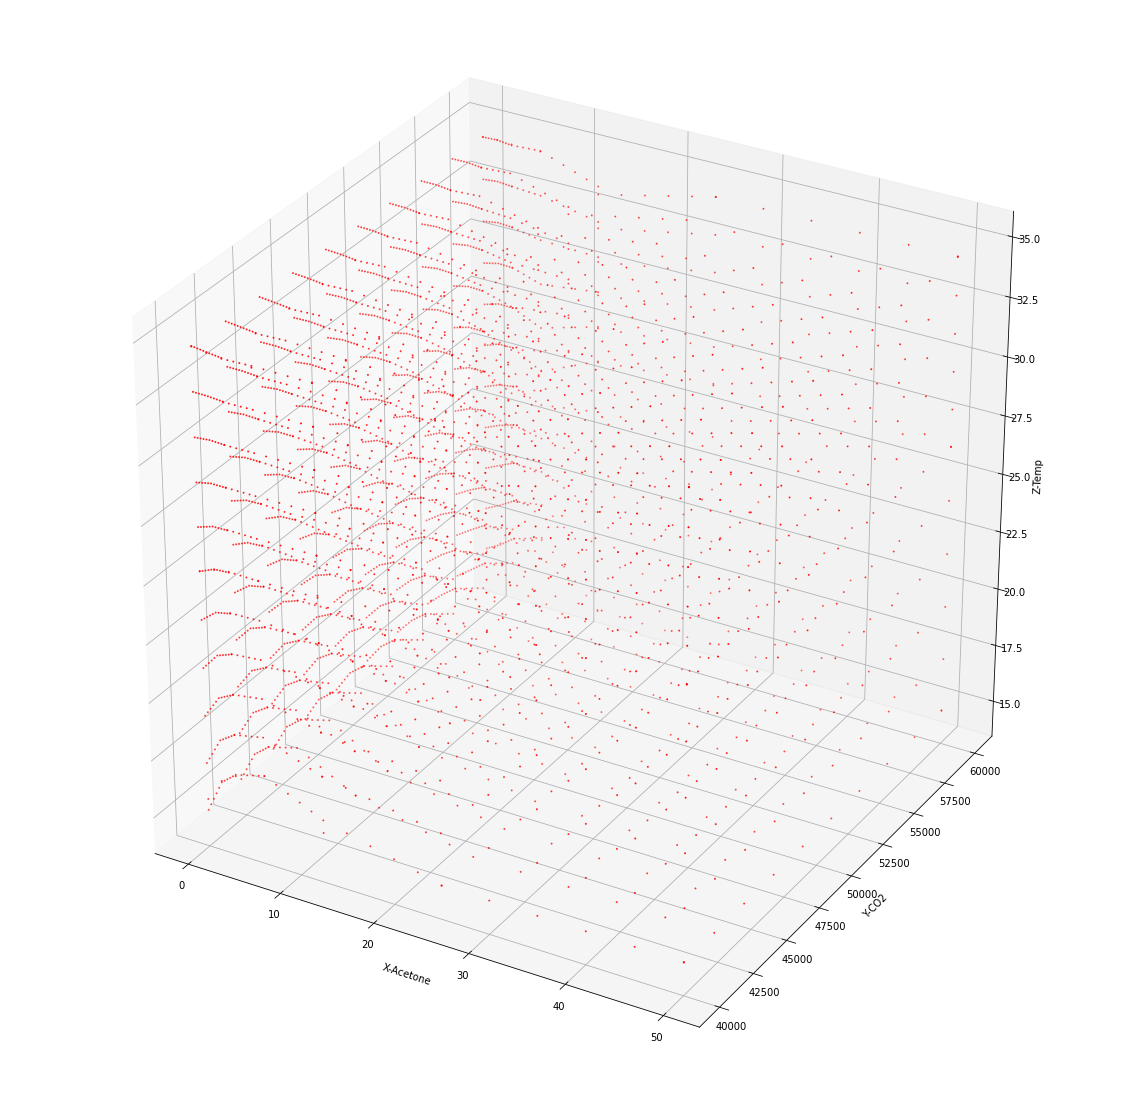

In [27]:
#db = make_db_from_get_test_list (fake_test_db_df, 'all', 'all', 10, 21, 100000, 9000000)
db = fake_test_db_df
print(len(db))
#plot points and fitted surface
X= db['Acetone']
Y =db['CO2']
Z =db['Instr_Temp']

# plot points and fitted surface
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
#ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(X, Y, Z, c='r', s=1)
plt.xlabel('X-Acetone')
plt.ylabel('Y-CO2')
ax.set_zlabel('Z-Temp')
ax.axis('tight')
plt.show()

In [ ]:

def get_test_temp_list (df, Acetone, ac_delta, CO2, H2O, temp, t_delta, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered[filtered['Acetone']>= Acetone - ac_delta]
                filtered = filtered[filtered['Acetone']<= Acetone + ac_delta]
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')


    filtered = filtered[filtered['Instr_Temp']>= temp - t_delta]
    filtered = filtered[filtered['Instr_Temp']<= temp + t_delta]
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])

25
2


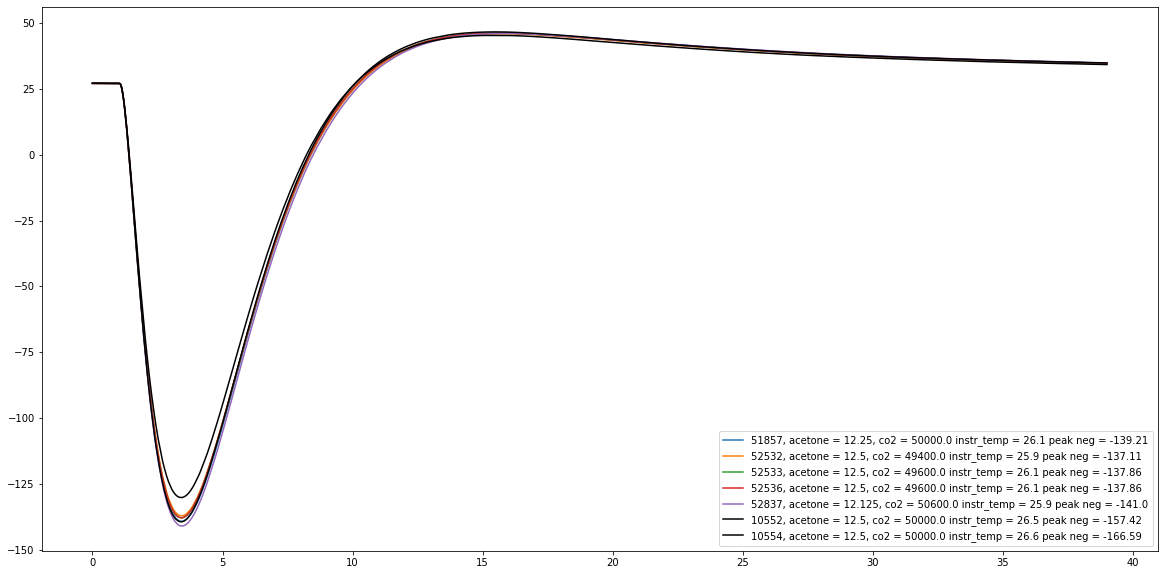

In [ ]:

test_list = get_test_temp_list(fake_test_db_df, 12.5, 0.5 , 5, 10, 26, 0.2, sensor_of_interest,10000,100000)
print(len(test_list))

real_test_list = get_test_temp_list(fake_test_db_df, 12.5, 0.5 , 5, 10, 25, 5, sensor_of_interest, 10000,10800 )
print(len(real_test_list))



plt.figure(figsize=(20,10))
for filenum in test_list[:5]:
  instr_temp = fake_test_db_df.loc[filenum, 'Instr_Temp']
  ac_val = fake_test_db_df.loc[filenum, 'Acetone']
  co2_val = fake_test_db_df.loc[filenum, 'CO2']
  peak_neg = fake_test_db_df.loc[filenum, 'Peak_neg']
  test_data = pd.read_csv(output_path + '/j_output'+ str(int(filenum)) + '.csv')
  plt.plot(test_data['Second'], test_data['mV_rolling_mean'], label = str(filenum) + ', acetone = ' + str(round(ac_val, 3)) + ', co2 = ' + str(round(co2_val, 0)) + ' instr_temp = ' + str(round(instr_temp,1)) + ' peak neg = ' + str(round(float(peak_neg),2)))
for filenum in real_test_list:
  instr_temp = fake_test_db_df.loc[filenum, 'Instr_Temp']
  ac_val = fake_test_db_df.loc[filenum, 'Acetone']
  co2_val = fake_test_db_df.loc[filenum, 'CO2']
  peak_neg = fake_test_db_df.loc[filenum, 'Peak_neg']
  path_1 = output_path + '/j_output'+ str(int(filenum)) + '.csv'
  path_2 = '/content/drive/My Drive/Test_outputs/jdata_9750/j_output' + str(int(filenum)) + '.csv'
  if os.path.exists(path_1):
    test_data = pd.read_csv(path_1)
  else:
    test_data = pd.read_csv(path_2)
  plt.plot(test_data['Second'], test_data['mV_rolling_mean'], label = str(filenum) + ', acetone = ' + str(round(ac_val, 3)) + ', co2 = ' + str(round(co2_val, 0)) + ' instr_temp = ' + str(round(instr_temp,1)) + ' peak neg = ' + str(round(float(peak_neg),2)), c= 'k')
plt.plot()
plt.legend()
plt.show()

In [ ]:
print(len(db))

28378


In [ ]:
fake_test_db_df.head(-1)

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Sample_rate,Sensor,Instr_Temp,Date,Time,Time_Btwn_s,Test_that_day,FLAG,Notes,Data_pts,Baseline,Amb_Temp,Other,Instr,Rel_Hum,EtOH_temp,Instr_T2,Instr_T3,New_Baseline,Baseline_Dip,Peak_neg,Peak_pos,Peak_neg_t,Peak_pos_t,Cross_t,Cross_t_ix,Peak_neg_t_ix,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,dx2_cross_t_ix,File_num,File
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9980,pdata9980,4% CO2 through plain water,10.0,40000.0,0.000,0.000000,250.0,21.0,25.780,2020-10-29,9:26:42 AM,100000.0,1.00,,,7500,138.58300,0,,4,42.06,0,25.9841,0,139.00,0.0008304911402,-300.2240579,27.8466,1.7120,10.68,6.74,1686,428,2670,0.00,0.0,-969.8170345,0,0,0,...,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,NaN,NaN
9983,pdata9983,4% CO2 through plain water,10.0,40000.0,0.400,0.000000,250.0,21.0,25.940,2020-10-29,9:34:41 AM,0.0,2.00,,,7500,138.82100,0,,4,42.43,0,26.1021,0,139.00,0.07628147,-303.5545987,27.822,1.7160,10.62,6.78,1694,429,2656,0.00,0.0,-983.4263148,0,0,0,...,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,NaN,NaN
9986,pdata9986,5% CO2 through plain water,10.0,50000.0,0.900,0.000000,250.0,21.0,26.400,2020-10-29,9:45:14 AM,0.0,3.00,,,7500,140.11700,0,,4,42.88,0,26.1343,0,140.00,0.04754124923,-367.9902041,35.7414,1.6640,10.56,6.72,1681,416,2640,0.00,0.0,-1195.330897,0,0,0,...,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,NaN,NaN
9989,pdata9989,5% CO2 through plain water,10.0,50000.0,1.400,0.000000,250.0,21.0,26.330,2020-10-29,9:51:04 AM,0.0,4.00,,,7500,139.62900,0,,4,43.90,0,26.0592,0,140.00,-0.02724432298,-370.1231435,35.9919,1.6680,10.56,6.74,1684,417,2641,0.00,0.0,-1206.066476,0,0,0,...,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,NaN,NaN
9992,pdata9992,6% CO2 through plain water,10.0,60000.0,2.000,0.000000,250.0,21.0,25.860,2020-10-29,10:02:10 AM,0.0,5.00,,,7500,139.06400,0,,4,43.85,0,25.7804,0,139.00,-0.07143262285,-407.5826633,44.0567,1.5160,10.42,6.60,1650,379,2604,0.00,0.0,-1329.169731,0,0,0,...,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254281,NaN,Combo of 10256 and 10046 | Weight - 0.46,10.0,54600.0,29.846,3.718750,250.0,21.0,30.860,NaN,NaN,0.0,15.44,NaN,NaN,7500,141.92604,NaN,NaN,4,NaN,NaN,NaN,NaN,142.16,NaN,-416.404,55.0015,1.448,10.408,6.384,1596,362,2602,NaN,NaN,-1356,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1264281.0
1254282,NaN,Combo of 10256 and 10046 | Weight - 0.47,10.0,54700.0,29.497,3.765625,250.0,21.0,30.775,NaN,NaN,0.0,15.58,NaN,NaN,7500,141.88728,NaN,NaN,4,NaN,NaN,NaN,NaN,142.12,NaN,-416.342,55.0625,1.448,10.408,6.38,1595,362,2602,NaN,NaN,-1355,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1264282.0
1254283,NaN,Combo of 10256 and 10046 | Weight - 0.82,10.0,58200.0,17.282,5.406250,250.0,21.0,27.800,NaN,NaN,0.0,20.48,NaN,NaN,7500,140.53068,NaN,NaN,4,NaN,NaN,NaN,NaN,14

In [ ]:
db.head(-1)

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old,Tests,File_num
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9600,pdata9600,4% CO2 through plain water,10.0,40000.0,0.400000,0.0000,NaN,0.0,1.0,19.0,2020-08-12,4:52:10,100000.000000,1.000000,40.21,NaN,26.970000,26.70,4.29,NaN,NaN,250.0,29739.0,138.590360,140.299732,1.7094,-201.494212,2.564,641.0,9.720,2430.0,21.255789,15.180,3795.0,NaN,NaN,-964.480165,NaN,NaN,531.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9600,NaN
9603,pdata9603,4% CO2 through plain water,10.0,40000.0,0.800000,0.0000,NaN,0.0,1.0,19.0,2020-08-12,5:02:22,612.000000,2.000000,41.68,NaN,26.380000,26.17,4.38,NaN,NaN,250.0,29762.0,138.598053,139.051119,0.4531,-214.762738,2.588,647.0,9.784,2446.0,22.320042,15.192,3798.0,NaN,NaN,-1031.707572,NaN,NaN,553.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9603,NaN
9606,pdata9606,6% CO2 through plain water,10.0,60000.0,1.400000,0.0000,NaN,0.0,1.0,19.0,2020-08-12,5:11:17,535.000000,3.000000,43.80,NaN,25.740000,25.51,4.29,NaN,NaN,250.0,29775.0,138.543365,139.034170,0.4908,-319.336814,2.584,646.0,9.896,2474.0,32.715501,15.228,3807.0,NaN,NaN,-1551.996551,NaN,NaN,863.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9606,NaN
9609,pdata9609,6% CO2 through plain water,10.0,60000.0,2.000000,0.0000,NaN,0.0,1.0,19.0,2020-08-12,5:20:20,543.000000,4.000000,43.88,NaN,25.390000,25.10,4.24,NaN,NaN,250.0,29766.0,138.240113,138.832362,0.5922,-321.963345,2.616,654.0,9.956,2489.0,33.050086,15.388,3847.0,NaN,NaN,-1574.392437,NaN,NaN,854.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9609,NaN
9612,pdata9612,4% CO2 through 1.5625 ppm acetone simulator,10.0,40000.0,2.400000,1.5625,NaN,0.0,1.0,19.0,2020-08-12,5:52:40,1940.000000,5.000000,40.49,NaN,26.040000,25.87,4.27,NaN,NaN,250.0,29744.0,138.525839,138.691733,0.1659,-175.652029,2.588,647.0,9.692,2423.0,19.664613,15.152,3788.0,NaN,NaN,-843.821572,NaN,NaN,436.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9612,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38246,NaN,Combo of 9738 and 9810 | Weight - 0.7931034482...,10.0,60000.0,32.917241,25.0000,NaN,NaN,1.0,19.0,NaN,NaN,539.413793,66.034483,NaN,NaN,31.075172,NaN,NaN,NaN,NaN,250.0,29771.0,142.305365,143.327371,NaN,-378.594255,2.120,530.0,7.460,1865.0,74.205702,12.516,3129.0,NaN,NaN,-1497.000000,NaN,NaN,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Remove tests from fake test log

In [ ]:
print(len(fake_test_db_df))

228787


In [ ]:
def remove_from_df (df, Sensor):


    filtered = df[(df['Sensor'] != Sensor)]

    return filtered

In [ ]:
fake_test_db_df = remove_from_df(fake_test_db_df, 10)
print(len(fake_test_db_df))

191731


In [ ]:
 fake_test_db_df.to_csv('/content/drive/My Drive/v3_Original_Fake_Test_Log.csv', index = False)

#Troubleshooting

In [ ]:
fake_test_db_df.set_index('File', inplace = True)

        Second  mV_rolling_mean
0        0.000        -0.508049
1        0.004        -0.508867
2        0.008        -0.513536
3        0.012        -0.516570
4        0.016        -0.516570
...        ...              ...
30121  120.484         7.031810
30122  120.488         7.030584
30123  120.492         7.030584
30124  120.496         7.026322
30125  120.500         7.021653

[30126 rows x 2 columns]
        Second  mV_rolling_mean
0        0.000        -0.314652
1        0.004        -0.314652
2        0.008        -0.314652
3        0.012        -0.313232
4        0.016        -0.308971
...        ...              ...
27452  109.808         6.468440
27453  109.812         6.468440
27454  109.816         6.468440
27455  109.820         6.468440
27456  109.824         6.468440

[27457 rows x 2 columns]
cross t for red one 8.712000000000005
cross t for blue one8.116000000000003
peak pos for red one 103.39837754638815
peak pos for blue one 90.66549020398749
peak pos time for red on

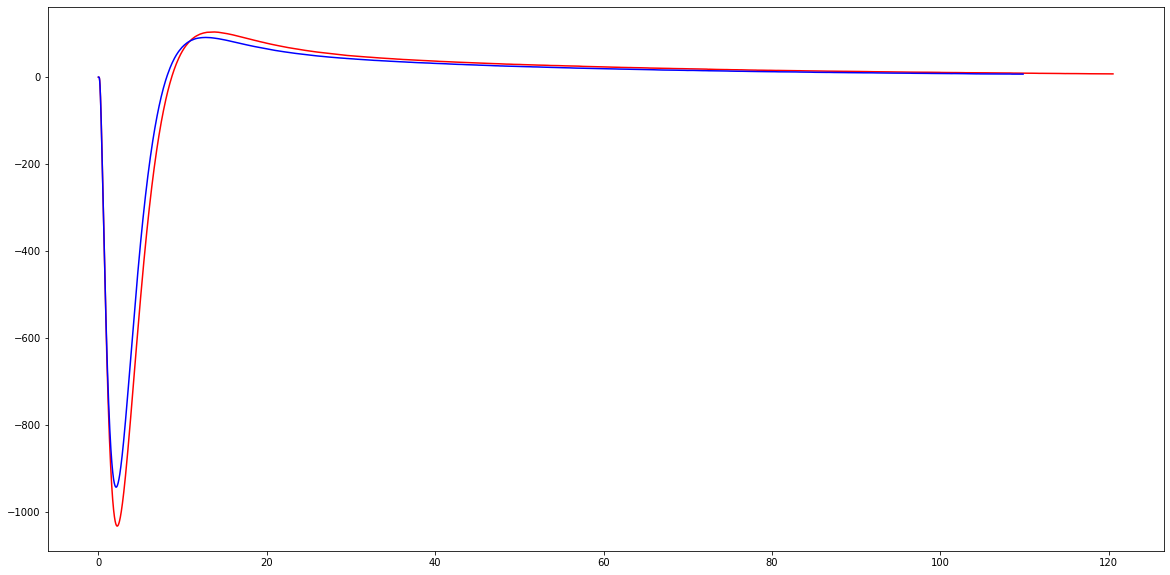

In [ ]:
bad_data = pd.read_csv('/content/drive/My Drive/Fakes_09/test_output62172.csv')
bad_data3 = pd.read_csv('/content/drive/My Drive/Fakes_09/test_output62173.csv')
bad_data2 = pd.read_csv('/content/drive/My Drive/Fakes_09/test_output10006.csv')
print(bad_data)
print(bad_data2)

xtime1 = fake_test_db_df.loc[62172, 'Cross_t']
xtime2 = fake_test_db_df.loc[10006, 'Cross_t']

pp1 = fake_test_db_df.loc[62172, 'Peak_pos']
pp2 = fake_test_db_df.loc[10006, 'Peak_pos']

pp1t = fake_test_db_df.loc[62172, 'Peak_pos_t']
pp2t = fake_test_db_df.loc[10006, 'Peak_pos_t']

pn1 = fake_test_db_df.loc[62172, 'Peak_neg']
pn2 = fake_test_db_df.loc[10006, 'Peak_neg']

plt.figure(figsize = [20,10])
plt.plot(bad_data['Second'], bad_data['mV_rolling_mean'], c= 'r')
plt.plot(bad_data2['Second'], bad_data2['mV_rolling_mean'], c= 'b')

print('cross t for red one ' + str(xtime1))
print('cross t for blue one' + str(xtime2))

print('peak pos for red one ' + str(pp1))
print('peak pos for blue one ' + str(pp2))

print('peak pos time for red one ' + str(pp1t))
print('peak pos time for blue one ' + str(pp2t))

print('peak neg for red one ' + str(pn1))
print('peak neg for blue one ' + str(pn2))

In [ ]:
fake_test_db_df.head()

,File,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old
0,200000.0,NaN,Combo of 5134 and 5262 | Weight - 0.79,10.0,42100.0,58.98,9.2125,NaN,NaN,38263.0,14.0,NaN,NaN,603.85,19.16,NaN,NaN,26.5967,NaN,NaN,NaN,NaN,250.0,55701.0,26.907357,27.085221,NaN,-395.676821,2.356,589.0,9.056,2264.0,45.245946,14.248,3562.0,NaN,NaN,-1770.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200001.0,NaN,Combo of 5134 and 5262 | Weight - 0.67,10.0,43300.0,55.14,8.7625,NaN,NaN,38263.0,14.0,NaN,NaN,602.05,18.68,NaN,NaN,27.9491,NaN,NaN,NaN,NaN,250.0,55701.0,27.999765,28.284850,NaN,-427.395069,2.332,583.0,8.900,2225.0,48.576854,14.248,3562.0,NaN,NaN,-1876.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200002.0,NaN,Combo of 5134 and 5262 | Weight - 0.94,10.0,40600.0,63.78,9.7750,NaN,NaN,38263.0,14.0,NaN,NaN,606.10,19.76,NaN,NaN,24.9062,NaN,NaN,NaN,NaN,250.0,55701.0,25.541849,25.585685,NaN,-356.231984,2.408,602.0,9.276,2319.0,41.082312,14.248,3562.0,NaN,NaN,-1638.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200003.0,NaN,Combo of 5134 and 5262 | Weight - 0.52,10.0,44800.0,50.34,8.2000,NaN,NaN,38263.0,14.0,NaN,NaN,599.80,18.08,NaN,NaN,29.6396,NaN,NaN,NaN,NaN,250.0,55701.0,29.365274,29.784387,NaN,-467.191336,2.288,572.0,8.728,2182.0,52.825978,13.876,3469.0,NaN,NaN,-2010.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200004.0,NaN,Combo of 5134 and 5262 | Weight - 0.52,10.0,44800.0,50.34,8.2000,NaN,NaN,38263.0,14.0,NaN,NaN,599.80,18.08,NaN,NaN,29.6396,NaN,NaN,NaN,NaN,250.0,55701.0,29.365274,29.784387,NaN,-467.191336,2.288,572.0,8.728,2182.0,52.825978,13.876,3469.0,NaN,NaN,-2010.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
peak_neg = bad_data['mV_rolling_mean'].min()
print(peak_neg)

peak_neg3 = bad_data3['mV_rolling_mean'].min()
print(peak_neg3)

-1031.3685903029034
-1103.298910574404


In [ ]:
test_db_df.head()

,Raw_data,Test_name,H2O,CO2,Total CO2,Acetone,Amb_Temp,Other,Instr,Sensor,Date,Time,Time_Btwn_s,Test_that_day,Rel_Hum,EtOH_temp,Instr_Temp,Instr_T2,Instr_T3,FLAG,Notes,Sample_rate,Data_pts,Baseline,New_Baseline,Baseline_Dip,Peak_neg,Peak_neg_t,Peak_neg_t_ix,Cross_t,Cross_t_ix,Peak_pos,Peak_pos_t,Peak_pos_t_ix,Area_neg_raw,Area_pos_raw,Area_neg,Area_pos_X,Area_total_X,Area_pos,...,Area_to_Cal_int,Area_Pos_to_Cal_int,Baseline_slope,slope_calc,flag_slope,a_,b_,c_,del_a,del_b,del_c,cpn_time,cpn_mV,cpn_manual_mV,cpn_manual_time,solve,solve2,del_pnt,del_ppt,del_xtime,del_cpnt,del_pn,del_pp,slope_pos_peak,slope_pos_peak_t,slope_pos_peak_t_ix,slope_neg_peak,slope_neg_peak_t,slope_neg_peak_t_ix,slope_cross_t,slope_cross_t_ix,dx2_pos_peak,dx2_pos_peak_t,dx2_pos_peak_t_ix,dx2_neg_peak,dx2_neg_peak_t,dx2_neg_peak_t_ix,dx2_cross_t,dx2_cross_t_ix,Area_pos_old
File,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3000,wav3000,Nitrogen blank,0,0,0.0,0.0,,0,38107,7,2020-02-11,13:53:44,50024,1.0,,,0.0,,,,,250,8076,26.770204,25.93022,-0.8400,-2.495264403,18.42,1842,,,34.06133447,1.32,132,,-1060,,,,2.67,...,,,0.13728,-0.73976,,,,,,,,,,,,,,,,,,,,0.6115311406,0.3,30,-0.1127246342,2.58,258,6.98,698,0.03976674596,0.21,21,-0.01064621545,0.45,45,1.88,188,
3001,wav3000,Nitrogen blank,0,0,0.0,0.0,,0,38263,6,2020-02-11,13:54:02,50042,1.0,,,0.0,,,,,250,6253,25.223295,25.26792,0.0446,-3.68E+00,10.28,1028,,,45.33028225,1.14,114,,1737,,,,18.17,...,,,0.07312,-0.62940,,,,,,,,,,,,,,,,,,,,0.9091349749,0.29,29,-0.145461596,2.57,257,8.25,825,0.06433878284,0.21,21,-0.01647321493,0.49,49,1.8,180,
3002,wav3001,Nitrogen blank,0,0,0.0,0.0,,0,38107,7,2020-02-11,13:56:27,163,2.0,,,0.0,,,,,250,5380,26.311880,26.37235,0.0605,-2.476566964,18.05,1805,,,38.78064916,1.27,127,,5373,,,,62.95,...,,,0.01004,-0.67635,,,,,,,,,,,,,,,,,,,,0.721437659,0.29,29,-0.1183608659,2.76,276,7.92,792,0.05009983743,0.22,22,-0.01189871139,0.48,48,1.76,176,
3003,wav3001,Nitrogen blank,0,0,0.0,0.0,,0,38263,6,2020-02-11,13:56:36,154,2.0,,,0.0,,,,,250,4455,25.250096,25.23670,-0.0134,-3.71E+00,11.82,1182,,,45.63916201,1.15,115,,5217,,,,51.52,...,,,0,-0.31470,,,,,,,,,,,,,,,,,,,,0.9063376365,0.3,30,-0.1398669192,2.44,244,8.37,837,0.06278470596,0.22,22,-0.01491913805,0.52,52,1.72,172,
3004,wav3002,Nitrogen blank,0,0,0.0,0.0,,0,38107,7,2020-02-11,14:04:19,472,3.0,,,0.0,,,,,250,4184,26.724979,26.90321,0.1782,-2.078048257,18.13,1813,,,32.95676806,1.29,129,,6489,,,,72.46,...,,,0.0067,-0.67635,,,,,,,,,,,,,,,,,,,,0.6058949089,0.3,30,-0.1042702866,2.47,247,7.64,764,0.04383735775,0.22,22,-0.009393719518,0.48,48,1.75,175,
